In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import pywt
from skimage.metrics import structural_similarity as ssim
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, Flatten, Dense, Reshape, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score

Load videos and extract frames

In [3]:
DATASET_PATH = "./Celeb-DF"
OUTPUT_FRAMES_PATH = "extracted_frames"
FRAME_INTERVAL = 5

os.makedirs(OUTPUT_FRAMES_PATH, exist_ok=True)

def extract_frames(video_path, save_path, interval=5):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    success, frame = cap.read()
    
    while success:
        if frame_count % interval == 0:
            frame_filename = os.path.join(save_path, f"frame_{frame_count}.jpg")
            cv2.imwrite(frame_filename, frame)
        success, frame = cap.read()
        frame_count += 1
    
    cap.release()

for folder in ["Celeb-real", "YouTube-real", "Celeb-synthesis"]:
    folder_path = os.path.join(DATASET_PATH, folder)
    output_folder = os.path.join(OUTPUT_FRAMES_PATH, folder)
    os.makedirs(output_folder, exist_ok=True)

    for video_name in tqdm(os.listdir(folder_path), desc=f"Processing {folder}"):
        video_path = os.path.join(folder_path, video_name)
        video_output_path = os.path.join(output_folder, video_name.split('.')[0])
        os.makedirs(video_output_path, exist_ok=True)

        extract_frames(video_path, video_output_path, FRAME_INTERVAL)

print("Frame extraction complete.")

Processing Celeb-synthesis: 100%|████████████████████████████████████████████████████| 795/795 [13:36<00:00,  1.03s/it]

Frame extraction complete.


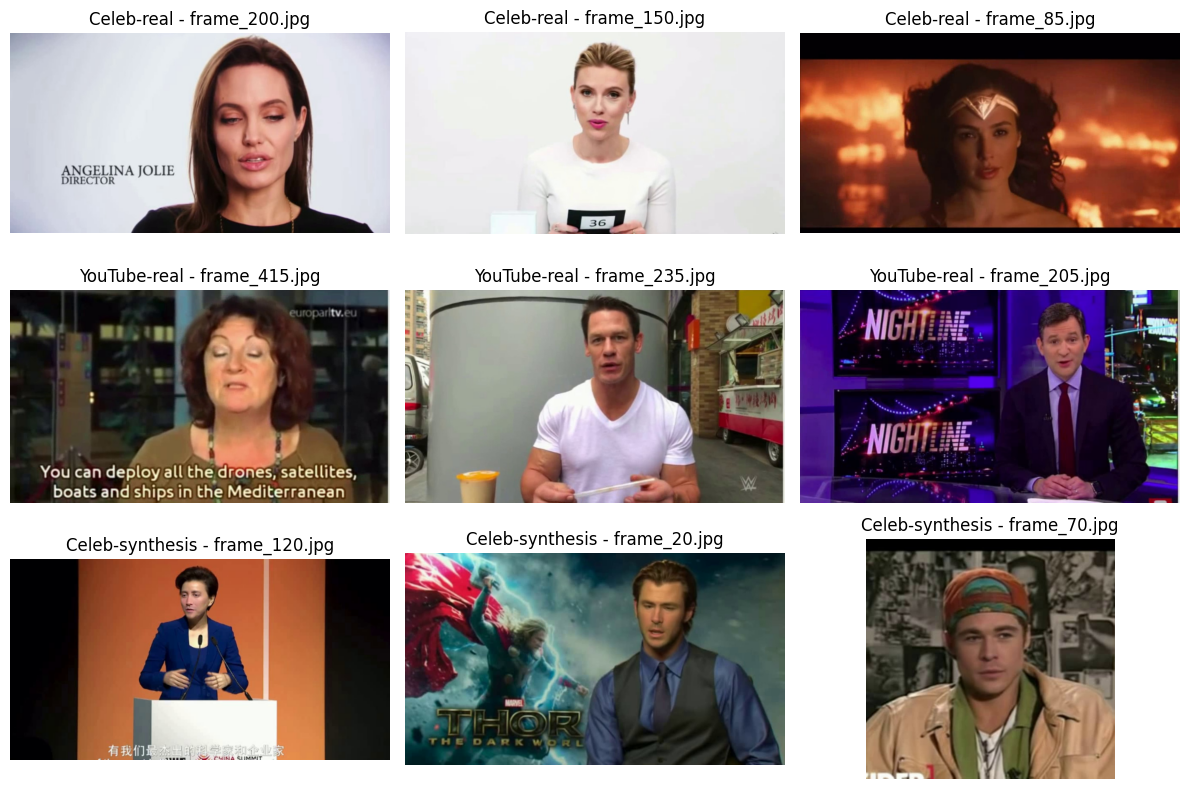

In [2]:
EXTRACTED_FRAMES_PATH = "extracted_frames"
FOLDERS = ["Celeb-real", "YouTube-real", "Celeb-synthesis"]

def get_random_frames(folder_path, num_frames=3):
    all_videos = os.listdir(folder_path)
    if len(all_videos) == 0:
        return []
    
    selected_videos = random.sample(all_videos, min(len(all_videos), num_frames))
    frames = []

    for video in selected_videos:
        video_folder = os.path.join(folder_path, video)
        if os.path.isdir(video_folder):
            frame_files = os.listdir(video_folder)
            if frame_files:
                random_frame = random.choice(frame_files)
                frame_path = os.path.join(video_folder, random_frame)
                frames.append(frame_path)
    
    return frames

fig, axes = plt.subplots(len(FOLDERS), 3, figsize=(12, 8))

for i, folder in enumerate(FOLDERS):
    folder_path = os.path.join(EXTRACTED_FRAMES_PATH, folder)
    random_frames = get_random_frames(folder_path)

    for j, frame_path in enumerate(random_frames):
        img = cv2.imread(frame_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i, j].imshow(img)
        axes[i, j].axis("off")
        axes[i, j].set_title(f"{folder} - {os.path.basename(frame_path)}")

plt.tight_layout()
plt.show()

Apply DWT + DCT for Watermarking

Using frame: extracted_frames/Celeb-real\id9_0008\frame_125.jpg


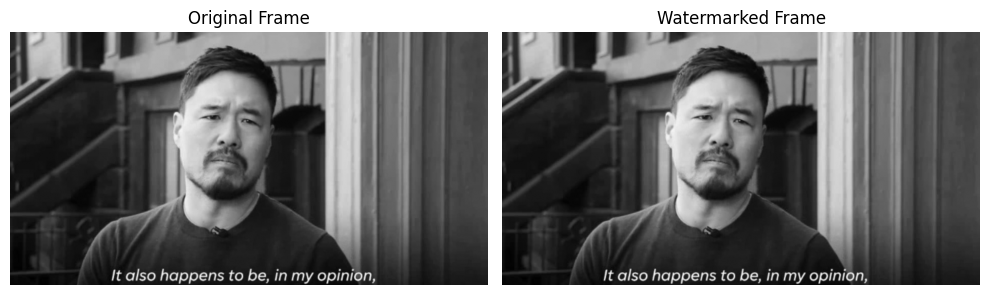

In [3]:
import os
import random
import cv2
import numpy as np
import pywt
import matplotlib.pyplot as plt

frame_folder = "extracted_frames/Celeb-real"

if not os.path.exists(frame_folder):
    raise FileNotFoundError(f"Frame directory not found: {frame_folder}")

video_folders = [f for f in os.listdir(frame_folder) if os.path.isdir(os.path.join(frame_folder, f))]
if not video_folders:
    raise FileNotFoundError("No video folders found in extracted_frames/Celeb-real")

selected_video = random.choice(video_folders)
video_path = os.path.join(frame_folder, selected_video)

frame_files = [f for f in os.listdir(video_path) if f.endswith(".jpg") or f.endswith(".png")]
if not frame_files:
    raise FileNotFoundError(f"No frames found in {video_path}")

sample_frame_path = os.path.join(video_path, random.choice(frame_files))
print(f"Using frame: {sample_frame_path}")

image = cv2.imread(sample_frame_path, cv2.IMREAD_GRAYSCALE)
if image is None:
    raise ValueError("Error loading image. Check file path or file format.")

def apply_dwt(image):
    coeffs = pywt.dwt2(image, 'haar')  
    LL, (LH, HL, HH) = coeffs
    return LL, LH, HL, HH, coeffs

def apply_dct(block):
    return cv2.dct(np.float32(block))

def apply_idct(block):
    return cv2.idct(block)

def embed_watermark(LL_subband, watermark):
    dct_LL = apply_dct(LL_subband)
    wm_resized = cv2.resize(watermark, (dct_LL.shape[1], dct_LL.shape[0]))
    alpha = 0.05 
    dct_LL += alpha * wm_resized
    return apply_idct(dct_LL)

def reconstruct_image(LL, LH, HL, HH):
    coeffs = (LL, (LH, HL, HH))
    return pywt.idwt2(coeffs, 'haar')

# Load user-provided watermark image
watermark = cv2.imread("watermark.jpg", cv2.IMREAD_GRAYSCALE)
if watermark is None:
    raise ValueError("❌ Failed to load watermark image.")
watermark = watermark / 255.0  # Normalize

LL, LH, HL, HH, coeffs = apply_dwt(image)

watermarked_LL = embed_watermark(LL, watermark)

watermarked_image = reconstruct_image(watermarked_LL, LH, HL, HH)

cv2.imwrite("watermarked_frame.jpg", (watermarked_image * 255).astype(np.uint8))  # Convert back to 0–255

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image, cmap='gray')
axes[0].set_title("Original Frame")
axes[0].axis("off")

axes[1].imshow(watermarked_image, cmap='gray')
axes[1].set_title("Watermarked Frame")
axes[1].axis("off")

plt.tight_layout()
plt.show()


GAN Architecture

In [4]:
rame_folder = "extracted_frames/Celeb-real"

video_folders = [f for f in os.listdir(frame_folder) if os.path.isdir(os.path.join(frame_folder, f))]
selected_video = random.choice(video_folders)
video_path = os.path.join(frame_folder, selected_video)

frame_files = [f for f in os.listdir(video_path) if f.endswith(".jpg") or f.endswith(".png")]
sample_frame_path = os.path.join(video_path, random.choice(frame_files))

image = cv2.imread(sample_frame_path, cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, (128, 128)) 


image = image / 255.0  
image = np.expand_dims(image, axis=-1)  
image = np.expand_dims(image, axis=0)   

def build_generator():
    input_layer = Input(shape=(128, 128, 1))
    
    x = Conv2D(64, (3, 3), padding='same')(input_layer)
    x = LeakyReLU()(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(1, (3, 3), padding='same', activation='sigmoid')(x)  

    return Model(input_layer, x, name="Generator")

def build_discriminator():
    input_layer = Input(shape=(128, 128, 1))
    
    x = Conv2D(64, (3, 3), padding='same')(input_layer)
    x = LeakyReLU()(x)
    x = Flatten()(x)
    x = Dense(1, activation='sigmoid')(x) 
    
    return Model(input_layer, x, name="Discriminator")

generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

discriminator.trainable = False
gan_input = Input(shape=(128, 128, 1))
watermarked_output = generator(gan_input)
gan_output = discriminator(watermarked_output)

gan_model = Model(gan_input, gan_output)
gan_model.compile(optimizer='adam', loss='binary_crossentropy')

generator.summary()
discriminator.summary()

Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 128, 128, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 128, 128, 1)         │           1,153 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 75,649 (295.50 KB)

 Trainable params: 75,649 (295.50 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1048576)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │       1,048,577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,049,217 (4.00 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,049,217 (4.00 MB)

In [5]:
import os
import random
import cv2
import numpy as np
import pywt

frame_folder = "extracted_frames/Celeb-real"
watermark_path = "./watermark.jpg"  # Change this path as needed

def apply_dwt(image):
    coeffs = pywt.dwt2(image, 'haar')  
    LL, (LH, HL, HH) = coeffs
    return LL, LH, HL, HH, coeffs

def apply_dct(block):
    return cv2.dct(np.float32(block))

def apply_idct(block):
    return cv2.idct(block)

def embed_watermark(LL_subband, watermark, alpha=0.05):
    dct_LL = apply_dct(LL_subband)
    wm_resized = cv2.resize(watermark, (dct_LL.shape[1], dct_LL.shape[0]))
    dct_LL += alpha * wm_resized
    return apply_idct(dct_LL)

def reconstruct_image(LL, LH, HL, HH):
    coeffs = (LL, (LH, HL, HH))
    return pywt.idwt2(coeffs, 'haar')

def load_watermark(path):
    wm = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if wm is None:
        raise ValueError(f"❌ Could not load watermark image from {path}")
    wm = cv2.resize(wm, (50, 50)) 
    wm = wm / 255.0  # Normalize
    return wm


def load_frames(num_samples=2000, frame_size=(128, 128), watermark_img=None):
    real_images = []
    watermarked_images = []

    video_folders = [f for f in os.listdir(frame_folder) if os.path.isdir(os.path.join(frame_folder, f))]
    if not video_folders:
        raise ValueError("No video folders found in the specified directory.")

    while len(real_images) < num_samples:
        selected_video = random.choice(video_folders)
        video_path = os.path.join(frame_folder, selected_video)
        frame_files = [f for f in os.listdir(video_path) if f.endswith((".jpg", ".png"))]
        if not frame_files:
            continue

        sample_frame_path = os.path.join(video_path, random.choice(frame_files))
        image = cv2.imread(sample_frame_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            continue

        image = cv2.resize(image, frame_size) / 255.0
        image = np.expand_dims(image, axis=-1)

        try:
            LL, LH, HL, HH, _ = apply_dwt(image.squeeze())
            watermarked_LL = embed_watermark(LL, watermark_img)
            watermarked_image = reconstruct_image(watermarked_LL, LH, HL, HH)

            watermarked_image = cv2.resize(watermarked_image, frame_size)
            watermarked_image = np.expand_dims(watermarked_image, axis=-1)

            real_images.append(image)
            watermarked_images.append(watermarked_image)
        except Exception as e:
            print(f"Skipping frame due to error: {e}")
            continue

        if len(real_images) % 100 == 0:
            print(f"✅ Loaded {len(real_images)}/{num_samples} frames...")

    real_images = np.array(real_images)
    watermarked_images = np.array(watermarked_images)
   
    print(f"🎉 Done! Loaded {len(real_images)} real frames and {len(watermarked_images)} watermarked frames.")
    return real_images, watermarked_images

# Load user watermark image once
user_watermark = load_watermark(watermark_path)

# Run the loader with the user watermark
real_images, watermarked_images = load_frames(4000, watermark_img=user_watermark)


✅ Loaded 100/4000 frames...
✅ Loaded 200/4000 frames...
✅ Loaded 300/4000 frames...
✅ Loaded 400/4000 frames...
✅ Loaded 500/4000 frames...
✅ Loaded 600/4000 frames...
✅ Loaded 700/4000 frames...
✅ Loaded 800/4000 frames...
✅ Loaded 900/4000 frames...
✅ Loaded 1000/4000 frames...
✅ Loaded 1100/4000 frames...
✅ Loaded 1200/4000 frames...
✅ Loaded 1300/4000 frames...
✅ Loaded 1400/4000 frames...
✅ Loaded 1500/4000 frames...
✅ Loaded 1600/4000 frames...
✅ Loaded 1700/4000 frames...
✅ Loaded 1800/4000 frames...
✅ Loaded 1900/4000 frames...
✅ Loaded 2000/4000 frames...
✅ Loaded 2100/4000 frames...
✅ Loaded 2200/4000 frames...
✅ Loaded 2300/4000 frames...
✅ Loaded 2400/4000 frames...
✅ Loaded 2500/4000 frames...
✅ Loaded 2600/4000 frames...
✅ Loaded 2700/4000 frames...
✅ Loaded 2800/4000 frames...
✅ Loaded 2900/4000 frames...
✅ Loaded 3000/4000 frames...
✅ Loaded 3100/4000 frames...
✅ Loaded 3200/4000 frames...
✅ Loaded 3300/4000 frames...
✅ Loaded 3400/4000 frames...
✅ Loaded 3500/4000 fram

Epoch 0/5000 - D Loss: 0.6931, G Loss: 0.6795
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
📏 Epoch 0: PSNR = 5.05 dB, SSIM = 0.0770


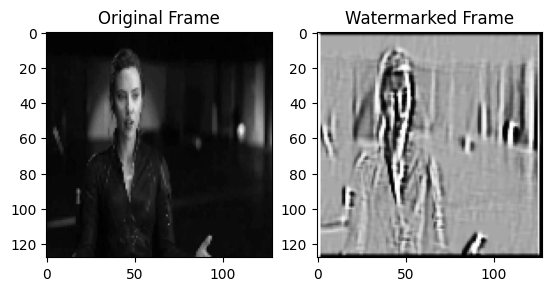

Epoch 100/5000 - D Loss: 0.6931, G Loss: 0.6759
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
📏 Epoch 100: PSNR = 8.90 dB, SSIM = 0.1109


Epoch 200/5000 - D Loss: 0.6931, G Loss: 0.6731
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
📏 Epoch 200: PSNR = 5.93 dB, SSIM = 0.0291


Epoch 300/5000 - D Loss: 0.6931, G Loss: 0.6710
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
📏 Epoch 300: PSNR = 8.01 dB, SSIM = 0.0452


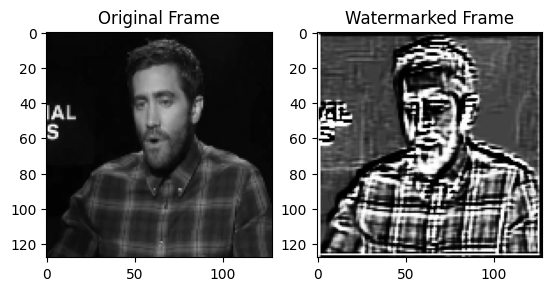

Epoch 400/5000 - D Loss: 0.6931, G Loss: 0.6695
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
📏 Epoch 400: PSNR = 8.13 dB, SSIM = 0.0554


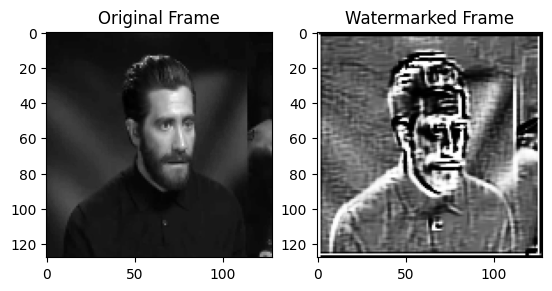

Epoch 500/5000 - D Loss: 0.6931, G Loss: 0.6681
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
📏 Epoch 500: PSNR = 6.57 dB, SSIM = 0.0805


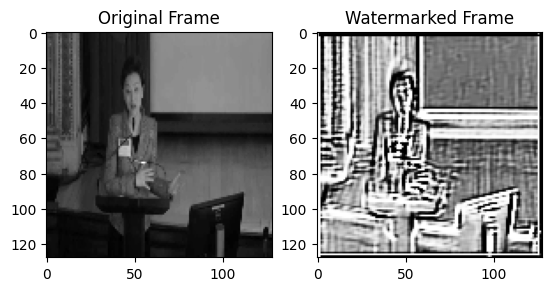

Epoch 600/5000 - D Loss: 0.6931, G Loss: 0.6670
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
📏 Epoch 600: PSNR = 5.79 dB, SSIM = 0.0293


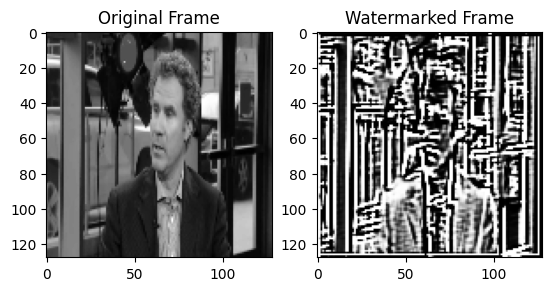

Epoch 700/5000 - D Loss: 0.6931, G Loss: 0.6660
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
📏 Epoch 700: PSNR = 7.17 dB, SSIM = 0.0407


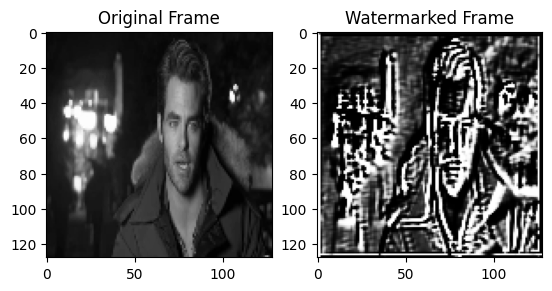

Epoch 800/5000 - D Loss: 0.6931, G Loss: 0.6652
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
📏 Epoch 800: PSNR = 8.04 dB, SSIM = 0.0428


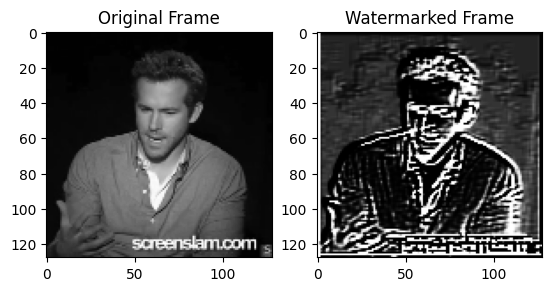

Epoch 900/5000 - D Loss: 0.6930, G Loss: 0.6645
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
📏 Epoch 900: PSNR = 4.68 dB, SSIM = 0.0258


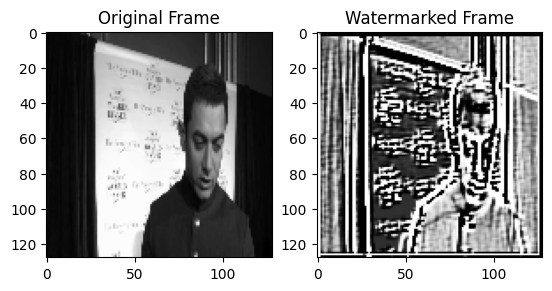

Epoch 1000/5000 - D Loss: 0.6930, G Loss: 0.6638
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
📏 Epoch 1000: PSNR = 5.16 dB, SSIM = 0.0474


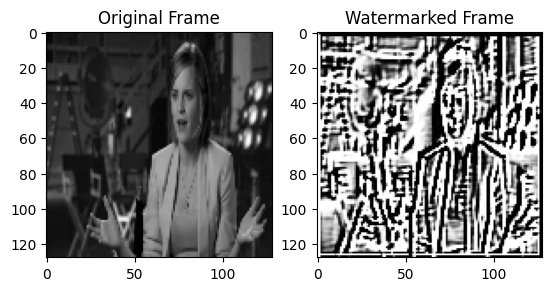

Epoch 1100/5000 - D Loss: 0.6930, G Loss: 0.6632
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
📏 Epoch 1100: PSNR = 3.81 dB, SSIM = -0.0013


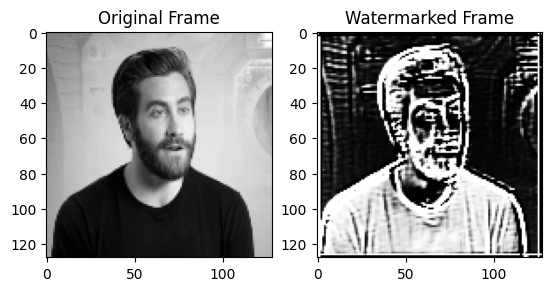

Epoch 1200/5000 - D Loss: 0.6930, G Loss: 0.6628
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
📏 Epoch 1200: PSNR = 6.19 dB, SSIM = 0.0407


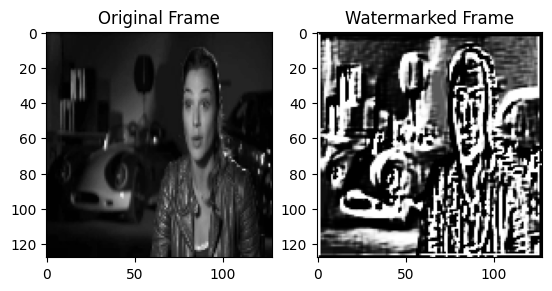

Epoch 1300/5000 - D Loss: 0.6930, G Loss: 0.6623
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
📏 Epoch 1300: PSNR = 2.72 dB, SSIM = 0.1416


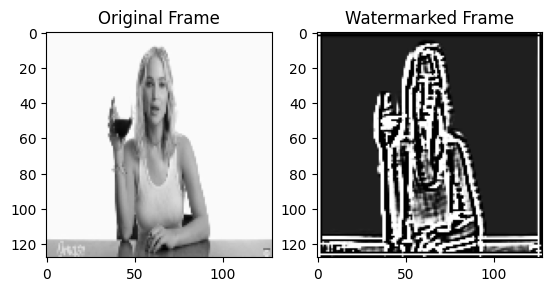

Epoch 1400/5000 - D Loss: 0.6930, G Loss: 0.6619
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
📏 Epoch 1400: PSNR = 4.58 dB, SSIM = 0.0506


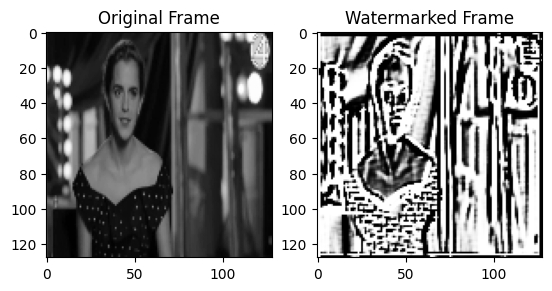

Epoch 1500/5000 - D Loss: 0.6930, G Loss: 0.6615
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
📏 Epoch 1500: PSNR = 6.11 dB, SSIM = 0.0683


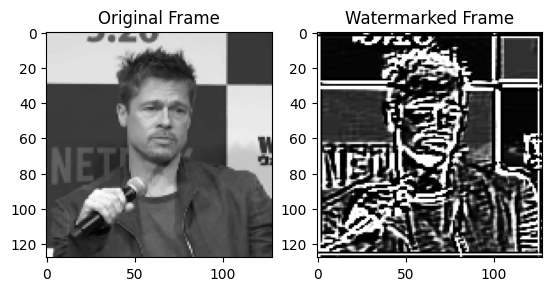

Epoch 1600/5000 - D Loss: 0.6930, G Loss: 0.6611
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
📏 Epoch 1600: PSNR = 6.42 dB, SSIM = 0.0499


Epoch 1700/5000 - D Loss: 0.6930, G Loss: 0.6608
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
📏 Epoch 1700: PSNR = 5.92 dB, SSIM = 0.0538


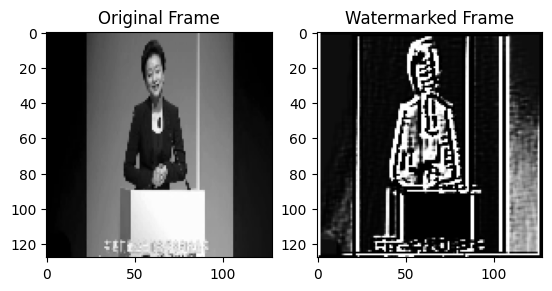

Epoch 1800/5000 - D Loss: 0.6930, G Loss: 0.6604
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
📏 Epoch 1800: PSNR = 4.41 dB, SSIM = 0.0166


Epoch 1900/5000 - D Loss: 0.6930, G Loss: 0.6601
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
📏 Epoch 1900: PSNR = 4.25 dB, SSIM = 0.0286


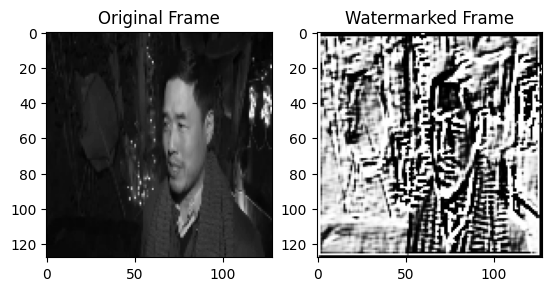

Epoch 2000/5000 - D Loss: 0.6930, G Loss: 0.6598
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
📏 Epoch 2000: PSNR = 5.32 dB, SSIM = 0.0304


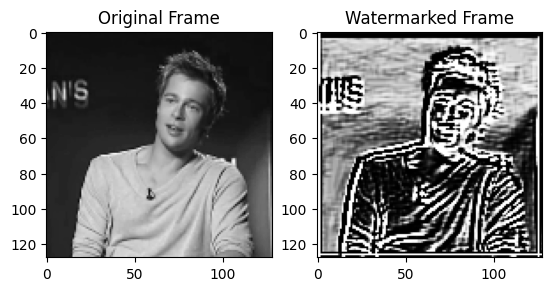

Epoch 2100/5000 - D Loss: 0.6930, G Loss: 0.6594
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
📏 Epoch 2100: PSNR = 7.05 dB, SSIM = 0.0334


Epoch 2200/5000 - D Loss: 0.6930, G Loss: 0.6591
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
📏 Epoch 2200: PSNR = 5.46 dB, SSIM = 0.0247


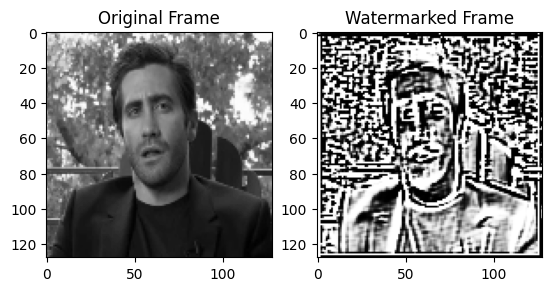

Epoch 2300/5000 - D Loss: 0.6930, G Loss: 0.6588
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
📏 Epoch 2300: PSNR = 6.37 dB, SSIM = 0.0506


Epoch 2400/5000 - D Loss: 0.6930, G Loss: 0.6585
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
📏 Epoch 2400: PSNR = 1.97 dB, SSIM = 0.0508


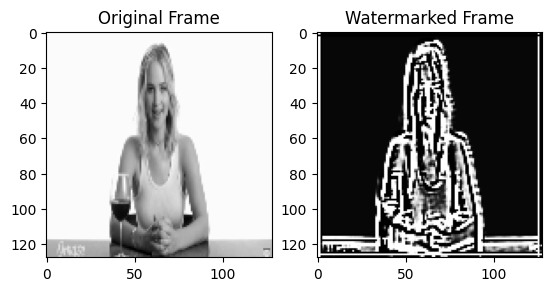

Epoch 2500/5000 - D Loss: 0.6930, G Loss: 0.6582
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
📏 Epoch 2500: PSNR = 3.36 dB, SSIM = 0.0232


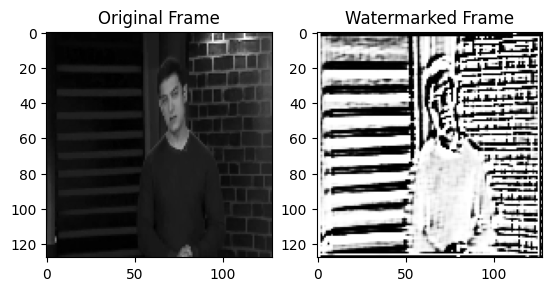

Epoch 2600/5000 - D Loss: 0.6930, G Loss: 0.6579
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
📏 Epoch 2600: PSNR = 6.17 dB, SSIM = 0.0320


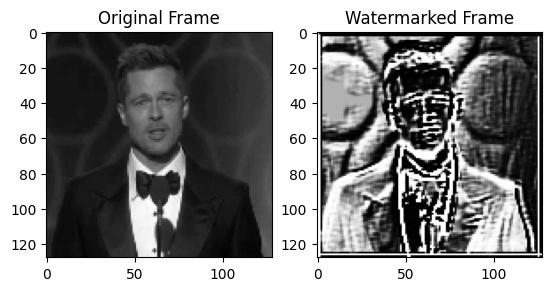

Epoch 2700/5000 - D Loss: 0.6930, G Loss: 0.6576
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
📏 Epoch 2700: PSNR = 4.84 dB, SSIM = 0.0319


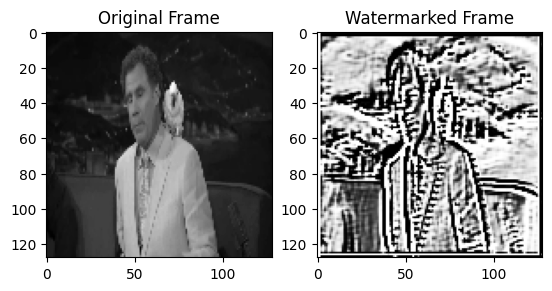

Epoch 2800/5000 - D Loss: 0.6930, G Loss: 0.6573
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
📏 Epoch 2800: PSNR = 5.21 dB, SSIM = 0.0072


Epoch 2900/5000 - D Loss: 0.6930, G Loss: 0.6570
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
📏 Epoch 2900: PSNR = 3.02 dB, SSIM = 0.0394


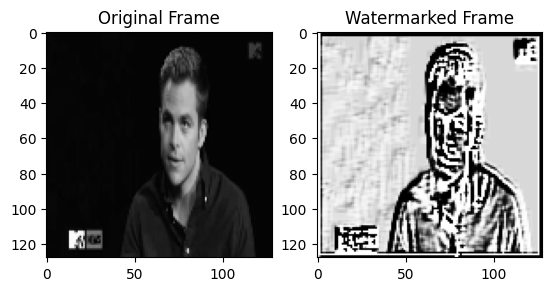

Epoch 3000/5000 - D Loss: 0.6930, G Loss: 0.6567
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
📏 Epoch 3000: PSNR = 5.27 dB, SSIM = 0.0187


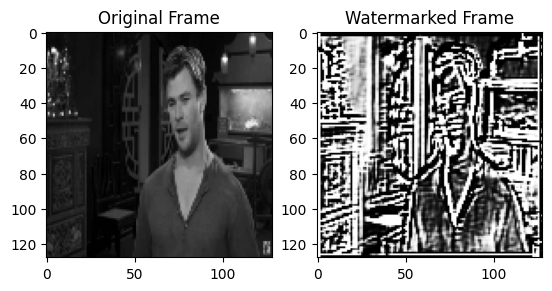

Epoch 3100/5000 - D Loss: 0.6930, G Loss: 0.6564
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
📏 Epoch 3100: PSNR = 5.86 dB, SSIM = 0.0662


Epoch 3200/5000 - D Loss: 0.6930, G Loss: 0.6561
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
📏 Epoch 3200: PSNR = 4.87 dB, SSIM = 0.0201


Epoch 3300/5000 - D Loss: 0.6930, G Loss: 0.6558
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
📏 Epoch 3300: PSNR = 6.00 dB, SSIM = 0.0408


Epoch 3400/5000 - D Loss: 0.6930, G Loss: 0.6555
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
📏 Epoch 3400: PSNR = 5.04 dB, SSIM = 0.0502


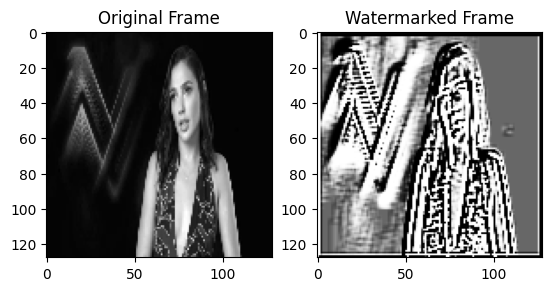

Epoch 3500/5000 - D Loss: 0.6930, G Loss: 0.6552
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
📏 Epoch 3500: PSNR = 7.87 dB, SSIM = 0.0287


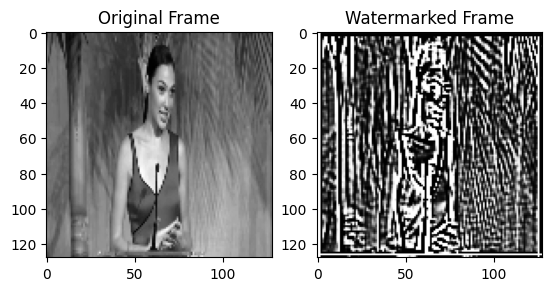

Epoch 3600/5000 - D Loss: 0.6930, G Loss: 0.6550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
📏 Epoch 3600: PSNR = 4.31 dB, SSIM = 0.0029


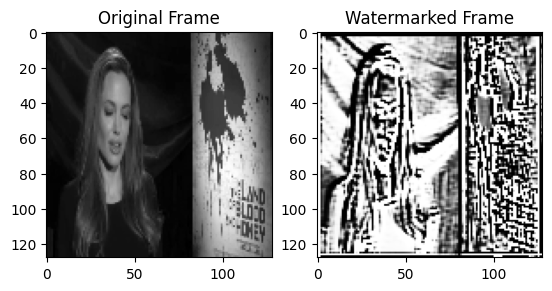

Epoch 3700/5000 - D Loss: 0.6930, G Loss: 0.6547
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
📏 Epoch 3700: PSNR = 4.94 dB, SSIM = 0.0585


Epoch 3800/5000 - D Loss: 0.6930, G Loss: 0.6544
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
📏 Epoch 3800: PSNR = 5.27 dB, SSIM = 0.0349


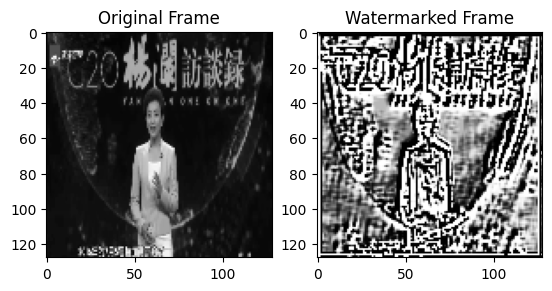

Epoch 3900/5000 - D Loss: 0.6930, G Loss: 0.6541
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
📏 Epoch 3900: PSNR = 8.14 dB, SSIM = 0.0261


Epoch 4000/5000 - D Loss: 0.6930, G Loss: 0.6538
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
📏 Epoch 4000: PSNR = 5.55 dB, SSIM = 0.0321


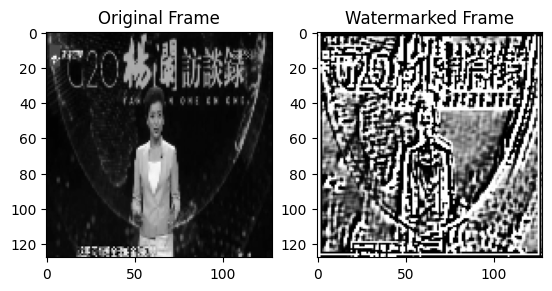

Epoch 4100/5000 - D Loss: 0.6930, G Loss: 0.6535
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
📏 Epoch 4100: PSNR = 7.56 dB, SSIM = 0.0365


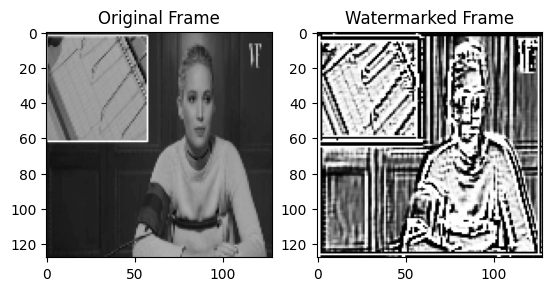

Epoch 4200/5000 - D Loss: 0.6930, G Loss: 0.6533
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
📏 Epoch 4200: PSNR = 7.70 dB, SSIM = 0.0730


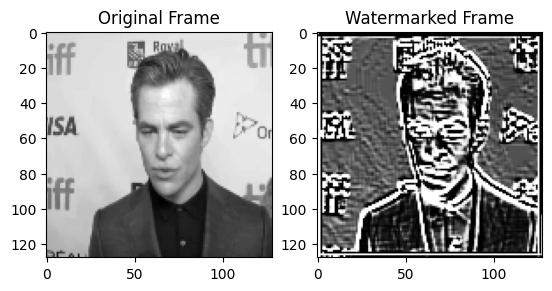

Epoch 4300/5000 - D Loss: 0.6930, G Loss: 0.6530
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
📏 Epoch 4300: PSNR = 5.16 dB, SSIM = 0.0236


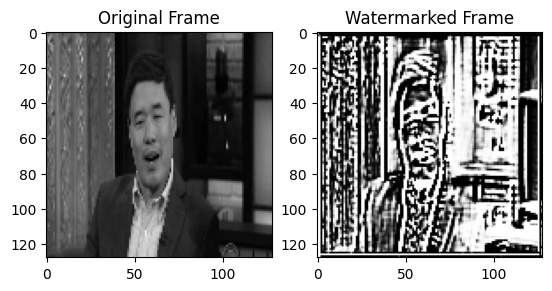

Epoch 4400/5000 - D Loss: 0.6930, G Loss: 0.6527
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
📏 Epoch 4400: PSNR = 5.64 dB, SSIM = 0.0196


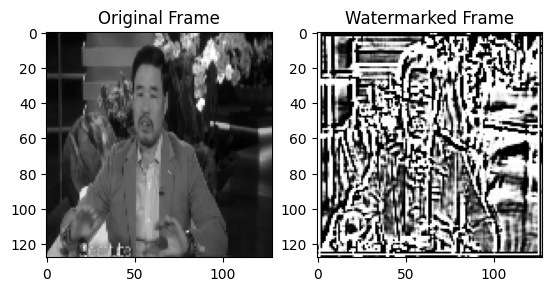

Epoch 4500/5000 - D Loss: 0.6930, G Loss: 0.6524
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
📏 Epoch 4500: PSNR = 5.76 dB, SSIM = 0.0316


Epoch 4600/5000 - D Loss: 0.6930, G Loss: 0.6521
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
📏 Epoch 4600: PSNR = 7.10 dB, SSIM = 0.0356


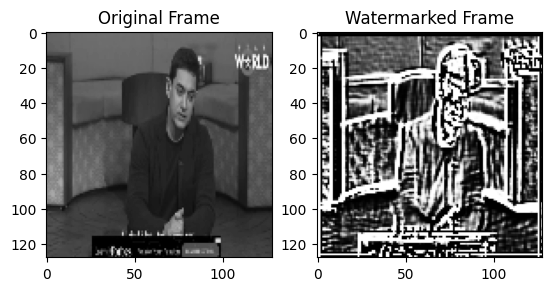

Epoch 4700/5000 - D Loss: 0.6930, G Loss: 0.6519
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
📏 Epoch 4700: PSNR = 5.80 dB, SSIM = 0.0348


Epoch 4800/5000 - D Loss: 0.6930, G Loss: 0.6516
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
📏 Epoch 4800: PSNR = 6.80 dB, SSIM = 0.0463


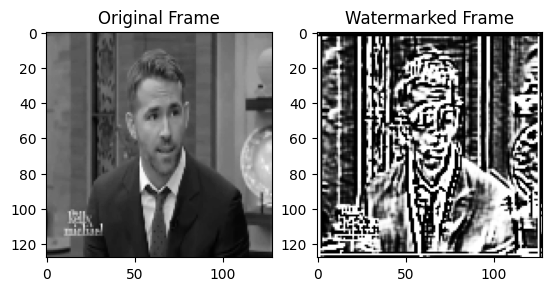

Epoch 4900/5000 - D Loss: 0.6930, G Loss: 0.6513
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
📏 Epoch 4900: PSNR = 5.33 dB, SSIM = 0.0244


In [10]:
from skimage.metrics import structural_similarity as ssim

weights_dir = "model_weights"
os.makedirs(weights_dir, exist_ok=True)

epochs = 5000
batch_size = 32

real_labels = np.ones((batch_size, 1))
fake_labels = np.zeros((batch_size, 1))

for epoch in range(epochs):
    idx = np.random.randint(0, real_images.shape[0], batch_size)
    real_imgs = real_images[idx]
    watermarked_imgs = watermarked_images[idx]

    d_loss_real = discriminator.train_on_batch(real_imgs, real_labels)
    d_loss_fake = discriminator.train_on_batch(watermarked_imgs, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    g_loss = gan_model.train_on_batch(real_imgs, real_labels)

    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{epochs} - D Loss: {d_loss[0]:.4f}, G Loss: {g_loss:.4f}")

        # Save model weights
        discriminator.save_weights(os.path.join(weights_dir, f"discriminator_epoch_{epoch}.weights.h5"))
        generator.save_weights(os.path.join(weights_dir, f"generator_epoch_{epoch}.weights.h5"))
        gan_model.save_weights(os.path.join(weights_dir, f"gan_model_epoch_{epoch}.weights.h5"))

        # Select a sample frame for evaluation
        sample_idx = np.random.randint(0, real_images.shape[0])
        sample_input = np.expand_dims(real_images[sample_idx], axis=0)
        generated_output = generator.predict(sample_input)[0]

        # Compute PSNR
        def compute_psnr(original, generated):
            mse = np.mean((original - generated) ** 2)
            if mse == 0:
                return 100
            max_pixel = 1.0  # Since images are normalized to [0,1]
            return 20 * np.log10(max_pixel / np.sqrt(mse))

        psnr_value = compute_psnr(real_images[sample_idx].squeeze(), generated_output.squeeze())

        # Compute SSIM
        ssim_value = ssim(real_images[sample_idx].squeeze(), generated_output.squeeze(), data_range=1.0)

        print(f"📏 Epoch {epoch}: PSNR = {psnr_value:.2f} dB, SSIM = {ssim_value:.4f}")

        # Display images
        fig, axs = plt.subplots(1, 2)
        axs[0].imshow(real_images[sample_idx].squeeze(), cmap="gray")
        axs[0].set_title("Original Frame")
        axs[1].imshow(generated_output.squeeze(), cmap="gray")
        axs[1].set_title("Watermarked Frame")
        plt.show()


Compute PSNR (Visual Quality Assessment)

In [ ]:
def compute_psnr(original, watermarked):
    watermarked_resized = cv2.resize(watermarked, (original.shape[1], original.shape[0]))

    mse = np.mean((original - watermarked_resized) ** 2)
    if mse == 0:
        return 100 
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

original_frame = cv2.imread(sample_frame_path, cv2.IMREAD_GRAYSCALE)
watermarked_frame = cv2.imread("watermarked_frame.jpg", cv2.IMREAD_GRAYSCALE)

psnr_value = compute_psnr(original_frame, watermarked_frame)
print(f"PSNR Value: {psnr_value:.2f} dB")

PSNR Value: 27.90 dB
